In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler  
from sklearn.model_selection import train_test_split
from  multiprocessing import cpu_count
from utils_plot import rmse, plot_comparisons, plot_feature_importances
import predictor
import optimizer
from itertools import combinations
from copy import deepcopy

%matplotlib inline

seed = 100
np.random.seed(seed)

# 1. Cross-Validation Tuning and Train

## Import data and preprocess

This dataset contains all the literature data + 87 experimental datapoints

In [2]:
with open('./full_data.json', 'r') as file:
    data = pd.read_json(json.load(file), orient='table')

data

,No,Units of A,Units of B,Units of C,Units of D,Units of E,M,Cloud Point
0,5,100.000000,0.000000,0.000000,0.000000,0,6700.0,90.6
1,6,150.000000,0.000000,0.000000,0.000000,0,9000.0,85.3
2,7,200.000000,0.000000,0.000000,0.000000,0,13300.0,78.3
3,8,300.000000,0.000000,0.000000,0.000000,0,21000.0,73.5
4,9,500.000000,0.000000,0.000000,0.000000,0,37300.0,69.3
5,10,0.000000,15.000000,0.000000,0.000000,0,3100.0,42.9
6,11,0.000000,20.000000,0.000000,0.000000,0,3700.0,39.0
7,12,0.000000,25.000000,0.000000,0.000000,0,4300.0,37.5
8,13,0.000000,50.000000,0.000000,0.000000,0,6200.0,30.3
9,14,0.000000,100.000000,0.000000,0.000000,0,8140.0,29.6


## CV Tuning with XGBoost

In [3]:
inputs = np.asarray(data.loc[:,'Units of A':'M'])
labels = np.asarray(data['Cloud Point'])

scaler_regressor = MinMaxScaler()
inputs = scaler_regressor.fit_transform(inputs)

inputs_train, inputs_valid, labels_train, labels_valid = train_test_split(
    inputs, labels, test_size=0.1, random_state=seed)

In [4]:
XGB_Options = { 
                'cv':               10,
                'scoring':          'neg_mean_squared_error',
                'seed':             seed, 
                'max_depth':        np.arange(2,14,2),
                'min_child_weight': np.arange(1,8,1),
                'n_estimators':     np.arange(10,80,5),

                'gamma':            np.arange(0.05,0.45,0.05),
                'colsample_bytree': np.arange(0.60, 0.95, 0.05),
                'subsample':        np.arange(0.60, 0.95, 0.05),
                'reg_alpha':        [1e-5, 1e-2, 0.1, 0.5, 1, 5, 10], #alpha 
                'reg_lambda':       [1e-5, 1e-2, 0.1, 0.5, 1, 5, 10],#lambda
                'learning_rate':    np.arange(0.025,0.150,0.025),
                'scaler':           scaler_regressor,
                'n_jobs':           4,
                'verbose':          1             
              }

In [5]:
trained_regressor =  predictor.XGB_Regressor(options=XGB_Options)
trained_regressor.fit(inputs_train, labels_train)
tuned_regressor = trained_regressor.regressor

Starting with low learning rate and tuning:             max_depth, min_child_weight, n_estimators
Fitting 10 folds for each of 588 candidates, totalling 5880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 1262 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 5880 out of 5880 | elapsed:    9.9s finished
/home/qianxiao/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


best_params_: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 75, 'subsample': 0.8}
best_score_: -42.1330943342157
Tuning: gamma
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.3s finished
/home/qianxiao/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


best_params_: {'colsample_bytree': 0.8, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 75, 'subsample': 0.8}
best_score_: -42.30700217055543
Tuning: colsample_bytree, subsample
Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    1.4s finished
/home/qianxiao/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


best_params_: {'colsample_bytree': 0.8500000000000002, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 75, 'subsample': 0.65}
best_score_: -38.46333754776491
Tuning: reg_alpha, reg_lambda
Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    1.3s finished
/home/qianxiao/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


best_params_: {'colsample_bytree': 0.8500000000000002, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 75, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.65}
best_score_: -38.05026087800712
Tuning: learning_rate
Fitting 10 folds for each of 5 candidates, totalling 50 fits
best_params_: {'colsample_bytree': 0.8500000000000002, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 75, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.65}
best_score_: -38.05026087800712
Final model


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.3s finished
/home/qianxiao/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [6]:
n_splits = 3
np.random.seed(seed)

targets = []
results = []

for n in range(n_splits):
    inputs_train, inputs_test, labels_train, labels_test = train_test_split(inputs, labels, test_size=0.1)
    tuned_regressor.fit(inputs_train, labels_train)
    pred_train = tuned_regressor.predict(inputs_train)
    pred_test = tuned_regressor.predict(inputs_test)
    results.append({'train': pred_train, 'test': pred_test, 'name': 'Split {}'.format(n+1)})
    targets.append({'train': labels_train, 'test': labels_test})

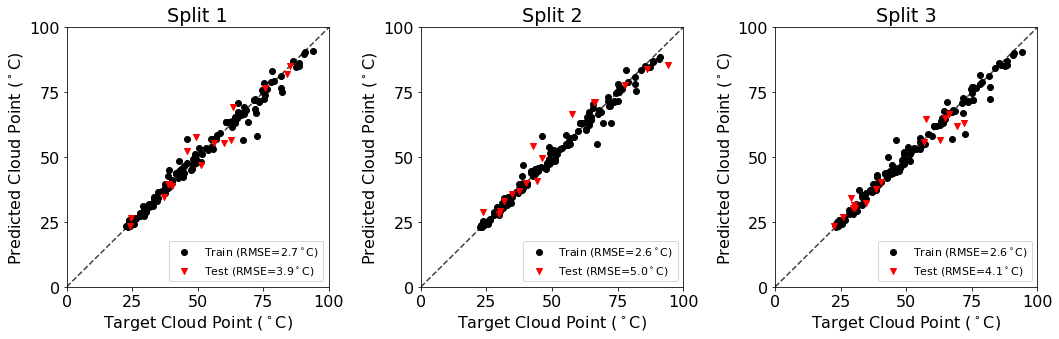

In [7]:
plot_comparisons(targets, results)

# 2. Train NN as Secondary Validation

In [8]:
import tensorflow as tf

tf.reset_default_graph()
np.random.seed(seed)
tf.set_random_seed(seed) 
sess = tf.Session()

In [9]:
NUM_NN = 10
regressors = []

for n in range(NUM_NN):
    options = {'input_shape': [6, ], 'target_shape': [1, ],
               'n_layers': 2, 'layer_widths': [64, 128], 
               'name': 'nn_{}'.format(n), 'session': sess}
    regressors.append(predictor.NeuralNetRegressor(options=options))

ensb_regressor = predictor.EnsembleRegressor(regressors, scaler_regressor)

In [10]:
options={'monitor': False,
         'reinitialize': True,
         'n_iter': 10000}
list_of_options = [options,]*NUM_NN
ensb_regressor.fit(inputs_train, labels_train.reshape(-1, 1), list_of_options)

Fitting Regressor: nn_0
Fitting Regressor: nn_1
Fitting Regressor: nn_2
Fitting Regressor: nn_3
Fitting Regressor: nn_4
Fitting Regressor: nn_5
Fitting Regressor: nn_6
Fitting Regressor: nn_7
Fitting Regressor: nn_8
Fitting Regressor: nn_9


In [11]:
predicted_train = ensb_regressor.predict_mean(inputs_train)
predicted_validation = ensb_regressor.predict_mean(inputs_valid)

train_rmse = rmse(predicted_train, labels_train)
validation_rmse = rmse(predicted_validation, labels_valid)

print('Train RMSE: ', train_rmse, 'validation RMSE: ', validation_rmse)

Train RMSE:  2.1540056388662414 validation RMSE:  1.576115105091678


### Train all data

In [ ]:
ensb_regressor.fit(inputs, labels.reshape(-1,1), list_of_options)

predicted_nn = ensb_regressor.predict_mean(inputs)
std_nn = np.sqrt(ensb_regressor.predict_covariance(inputs))
rmse_nn = rmse(predicted_nn, labels)

Fitting Regressor: nn_0
Fitting Regressor: nn_1
Fitting Regressor: nn_2
Fitting Regressor: nn_3
Fitting Regressor: nn_4
Fitting Regressor: nn_5
Fitting Regressor: nn_6
Fitting Regressor: nn_7
Fitting Regressor: nn_8
Fitting Regressor: nn_9


# 3. Inverse Design

## Train model with tuned parameters on the full dataset

In [ ]:
trained_regressor.regressor.fit(inputs, labels)
predicted = trained_regressor.predict(inputs)
print('Train RMSE: ', rmse(predicted, labels))

Train RMSE:  2.298679070874118


## Constraint and Target Specifications

We solve the problem
$$
    \min_{x} \mathrm{objective}(x, CP)
$$
subject to
$$
    \mathrm{constraints}(x) \geq 0
$$

Some soft constraints are written into the objective function as a regularizer, and some hard constraints are moved to the selection criterion function, which must evaluates to true before we consider the solution admissiable. This is to maximize efficiency of the particle swarm method.

In [ ]:
lb = np.array([0]*6)
ub = np.array([203, 187, 43, 96, 0.1, 23196])

def objective(x, target_CP, regressor):
    '''
    loss function:
        The loss function contains 2 parts
            1. 0.5*(predicted_CP(x) - target_CP)**2
            2. coef * regularizer
    '''
    
    def regularizer(x):
        '''
        Regularizer (or soft constraints):
            We want to drive the system towards
            binary systems involving A,B,C,D
            Here, we use the simple penalizer
                \sum_{(i,j,k) \in (A,B,C,D)} i*j*k

            For task 1:
                We also want to minimize A
        '''
        reg = 0.0
        for c in combinations(x[:4], 3):
            reg += np.prod(c)**(1.0/3.0)

        reg += x[0]  # minimize A
        return reg

    
    return 0.5 * (regressor.predict_transform(x) - target_CP)**2 \
        + 1e-1 * regularizer(x)


def constraints(x, *args):
    ''' hard constraints '''
    Final_M    = np.dot(x[:4], [99.13, 113.16, 111.14, 113.16])
    cons_Mp_ub = [Final_M * 1.2 - x[5]]
    cons_Mp_lb = [x[5] - Final_M * 0.8]
    return np.asarray(cons_Mp_ub + cons_Mp_lb) 

def selection_criteria(x):
    """
    Selection criteria:
        Desired solution x should evaluates to all
        non-negative
            1. Minimum non-zero component must be at least 10%
               of the max component. (note: non-zero is defined
               to be <= ZERO_CUTOFF, purely for numerical stability)
            2. Allow for at most ternary systems
    """
    ZERO_CUTOFF    = 0.1    

    # Criterion 1
    xcomps         = x[:4]
    x_non_zero     = xcomps[xcomps > ZERO_CUTOFF]
    x_max          = xcomps.max()
    x_min          = x_non_zero.min()
    comp_condition = [x_min - 0.1*x_max]

    # Criterion 2
    num_non_zero      = np.sum(x[:4] > ZERO_CUTOFF)
    nonzero_condition = [3.1 - num_non_zero]
    # return np.asarray([1.0])
        
    return all([c >= 0 for c in comp_condition + nonzero_condition])

## Optimze via Particle Swarm Optimizer

The optimisation options are found using a systematic parameter study that we omit here for brevity

In [ ]:
opt = optimizer.PSO_Optimizer(
    regressor=trained_regressor,
    scaler=scaler_regressor,
    objective=objective,
    constraints=constraints,
    selection_criteria=selection_criteria
)

optimisation_options = { 'criteria': 0.1,
                        'max_rounds': 200,
                        'n_solutions': 50,
                        'lb':lb, 'ub':ub, 
                        'opt_vars': [ 'Units of A', 'Units of B', 'Units of C', 'Units of D', 'Units of E', 'M'],
                        'swarmsize': 400, 'omega':0.1, 'phip':0.9, 'phig': 0.8, 'maxiter': 100, 
                        'debug_flag': False,
                        'nprocessors': 12
                       } 

### 1. Target = 37$^{\circ}$C

In [ ]:
optimisation_options['target_CP'] = 37
results37, runtime  =  opt.optimisation_parallel(optimisation_options)
results37

Optimisation sequence started at time:
2018-11-16 01:27:16
Working on round: 1
Optimization No.: 1
Optimization No.: 2
Optimization No.: 3
Optimization No.: 5
Optimization No.: 4
Optimization No.: 6
Optimization No.: 7
Optimization No.: 8
Optimization No.: 9
Optimization No.: 10
Optimization No.: 11
Optimization No.: 12
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100


,Pred_Units of A,Pred_Units of B,Pred_Units of C,Pred_Units of D,Pred_Units of E,Pred_M,Pred_Cloud Point,Pred_% Error,target_CP
0,0.000000e+00,32.501030,1.344265e+01,59.476440,0.048605,13494.428417,37.008938,0.000242,37
1,0.000000e+00,44.749701,1.444176e+01,24.002974,0.034459,11117.781872,36.986992,0.000352,37
2,2.223224e+01,89.043777,1.016919e+01,0.000000,0.046091,16087.743970,37.021591,0.000584,37
3,2.224262e+01,87.191618,2.083490e+01,0.000000,0.062140,16307.432298,37.021591,0.000584,37
4,0.000000e+00,33.310808,1.013142e+01,70.880542,0.029078,14908.305290,36.975338,0.000667,37
5,0.000000e+00,0.000000,2.911059e+01,82.920393,0.027676,12645.644434,36.967987,0.000865,37
6,0.000000e+00,37.699788,2.013649e+01,17.690809,0.095356,10119.292327,36.962261,0.001020,37
7,1.952018e+01,64.005698,0.000000e+00,56.697090,0.085855,17947.680515,36.951569,0.001309,37
8,0.000000e+00,39.403614,7.180058e+00,31.532815,0.069093,10574.355994,36.946568,0.001444,37
9,2.634883e+01,69.437444,0.000000e+00,23.294073,0.062827,14678.865465,37.053593,0.001448,37


### 2. Target = 45$^{\circ}$C

In [ ]:
optimisation_options['target_CP'] = 45
results45, runtime  =  opt.optimisation_parallel(optimisation_options)
results45

Optimisation sequence started at time:
2018-11-16 01:43:54
Working on round: 1
Optimization No.: 1
Optimization No.: 2
Optimization No.: 3
Optimization No.: 5
Optimization No.: 6
Optimization No.: 4
Optimization No.: 8
Optimization No.: 7
Optimization No.: 9
Optimization No.: 10
Optimization No.: 11
Optimization No.: 12
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iteration

### 3. Target = 60$^{\circ}$C

In [ ]:
optimisation_options['target_CP'] = 60

results60, runtime  =  opt.optimisation_parallel(optimisation_options)
results60

### 4. Target = 80$^{\circ}$C

In [ ]:
optimisation_options['target_CP'] = 80
results80, runtime  =  opt.optimisation_parallel(optimisation_options)
results80

## NN validation of the XGB results

In [ ]:
def NN_Mean_Std(input_df, scaler, ensb_reg):
    
    data = deepcopy(input_df)
    inputs   = scaler_regressor.transform(data.iloc[:, :6 ].values)
    
    mean = ensb_regressor.predict_mean(inputs)
    cov  = ensb_regressor.predict_covariance(inputs)
    std  = np.sqrt(cov.squeeze())
    
    data['Mean_Pred_NN'] = mean
    data['Std_Error_NN']  = std
    
    data['%Error_Mean_Pred_NN'] = 100*(data.Mean_Pred_NN - data.target_CP)/data.target_CP
    
    
    return data

In [ ]:
NN_validation37 = NN_Mean_Std(results37, scaler_regressor, ensb_regressor)
NN_validation37

In [ ]:
NN_validation45 = NN_Mean_Std(results45, scaler_regressor, ensb_regressor)
NN_validation45

In [ ]:
NN_validation60 = NN_Mean_Std(results60, scaler_regressor, ensb_regressor)
NN_validation60

In [ ]:
NN_validation80 = NN_Mean_Std(results80, scaler_regressor, ensb_regressor)
NN_validation80